#import statements

In [1]:
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google-auth-oauthlib google-auth-httplib2
# !pip install python-dotenv
# !pip install -q transformers
# !pip3 install emoji==0.6.0
# !pip install reportlab

In [2]:
from googleapiclient.discovery import build
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
VIDEO_ID = "kU0SJTmdFp4" #https://www.youtube.com/watch?v=kU0SJTmdFp4
# VIDEO_ID = "5xEi8qg266g" #https://www.youtube.com/watch?v=5xEi8qg266g | Video Title: Why Do Movies Feel So Different Now?
# VIDEO_ID = "eoAAJFZaFp4"
youtube = build('youtube', 'v3', developerKey=os.getenv('API_KEY'))

In [5]:
video_details = youtube.videos().list(
    part='snippet',
    id=VIDEO_ID
).execute()
video = video_details['items'][0]
video_context = {
    "id" : video["id"],
    "video_author" : video['snippet']['channelTitle'],
    "title" : video['snippet']['title'],
    "description" : video['snippet']['description'],
    "published_date" : video['snippet']['publishedAt'],
}

In [6]:
response = youtube.commentThreads().list(
part='snippet',
videoId=VIDEO_ID,
textFormat='plainText',
maxResults=100  # Set the number of comments you want to retrieve | This is overridden later
).execute()

In [7]:
# # This is for testing purposes
# cmtSnippet = response['items'][0]['snippet']['topLevelComment']['snippet']
# print(cmtSnippet['authorChannelId']['value'])

In [8]:
comments = []
while response:
    for item in response['items']:
        topLevelCommentSnippet = item['snippet']['topLevelComment']['snippet']
        authorDisplayName = topLevelCommentSnippet['authorDisplayName']
        authorChannelId = topLevelCommentSnippet['authorChannelId']['value'] if 'authorChannelId' in topLevelCommentSnippet else ''
        comment = topLevelCommentSnippet['textDisplay']
        commentLastUpdated = topLevelCommentSnippet['updatedAt']
        comments.append([authorDisplayName,authorChannelId,comment, commentLastUpdated])
    
    if 'nextPageToken' in response:
        next_page_token = response['nextPageToken']
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=VIDEO_ID,
            textFormat='plainText',
            pageToken=next_page_token,
            maxResults=10 
        ).execute()
    else:
        break


In [9]:
import pandas as pd
from datetime import *
from collections import Counter
import re 
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [10]:
#Create a dataFrame
total_comments_df = pd.DataFrame(comments, columns=["author_display_name", "author_channel_id", "comment", "comment_last_updated"])

In [11]:
# stopwords
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

def decontracted(phrase):
    phrase = re.sub(r"\’", "\'", phrase)
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"shoudn\'t", "shoul not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"doesn\'t", "doesn not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_comments(contents):
    contents = decontracted(contents)

    # remove any stop words present
    contents = contents.lower().strip()
    contents = ' '.join([item for item in contents.split() if item not in stop])
    
    # remove punctuations
    contents = ''.join(ch for ch in contents if ch not in exclude)
    contents = re.sub(r'@[A-Za-z0-9_]+','', contents)

    # Removing Hyperlinks (if any)
    contents = re.sub(r"(https?://[^\s]+)", '', contents)
    contents = re.sub(r"[-()\'\"/;:<>{}`+=~|.!?,…—]", "", contents)

    return contents

In [12]:
total_comments_df['clean_comment'] = total_comments_df['comment'].apply(clean_comments)
total_comments_df.dropna(axis='rows')

,author_display_name,author_channel_id,comment,comment_last_updated,clean_comment
0,The Head And The Heart,UCC9TsJPWWkXLLY5kJdiQPtg,We're so excited for you all to finally see th...,2020-02-03T15:48:32Z,excited finally see honeybee music video let u...
1,Fyness Ngwira,UCyGFzZdcEB9Be-daKJk4X2g,I was watching About fate...... This is a love...,2023-06-07T16:47:54Z,watching fate lovely song
2,Molly Lara,UCv6j2M8Yv0dqOpK6msoGXbw,I love the video so much it's so cute and I li...,2023-06-02T17:01:35Z,love video much cute like everything ittt rain...
3,NBA Insider,UCKfqX1JE76JWkHeQnr_r3nw,hi,2023-05-31T06:13:06Z,hi
4,Crypto Bee,UC2mf7VwoUix3BsA_lRsWVXw,This song MUST be about a woman named MELISSA....,2023-05-30T07:13:35Z,song must woman named melissa melissa translat...
...,...,...,...,...,...
695,Argh,UCGh2O9DdyfwDEp7VfrzSJDg,What are your favorite unreleased songs? (Rece...,2020-02-01T18:26:53Z,favorite unreleased songs recent time
696,Sal Nigro,UCBfTZWRDag5uR7gPYeEKtiQ,Will Josiah be back on the new recordings and ...,2020-02-01T18:18:21Z,josiah back new recordings dvd release
697,Diana Laura,UCkTbWyav3CIF0ufcru7bcPA,"Who wrote ""honeybee""?",2020-02-01T17:54:48Z,wrote honeybee
698,Delia Avila,UC73C0-rUr7sdluZUj1u9gcQ,You are coming to Mankato Minnesota!!! Yasss!!!,2020-02-01T17:28:53Z,coming mankato minnesota yasss


In [13]:
total_comments_df['comment_last_updated'] = pd.to_datetime(total_comments_df['comment_last_updated']).dt.tz_convert(timezone.utc)
total_comments_df.to_csv("./comments.csv")

In [14]:
# 100 comments takes around 20 seconds
# 3200 comments takes around 12 minutes to process
# comments_df = total_comments_df.head(1000)
comments_df = total_comments_df

In [15]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-roberta-base-sentiment", device=-1)
data = (comments_df["clean_comment"]).to_list()
labels = {"LABEL_0": "Negative", "LABEL_1":"Neutral", "LABEL_2":"Positive"}
sentiment_values = {"LABEL_0":-1, "LABEL_1":0, "LABEL_2":1}

In [16]:
sentiment_obj = []
sentiment_label = []
sentiment_val = []
sentiment_count = {"LABEL_0":0, "LABEL_1":0, "LABEL_2":0}

for item in data:
    result = nlp(item, truncation=True, max_length=512)  # Adjust max_length parameter and enable truncation
    sentiment_obj.append(result[0])
    sentiment_label.append(labels[result[0]['label']])
    sentiment_val.append(sentiment_values[result[0]['label']])
    sentiment_count[result[0]['label']] = sentiment_count[result[0]['label']] + 1

In [17]:
comments_df["sentiment_obj"] = sentiment_obj
comments_df["sentiment"] = sentiment_label
comments_df["sentiment_values"] = sentiment_val

In [18]:
import matplotlib.pyplot as plt

In [25]:
sentiment_label = list(map(lambda x : labels[x], list(sentiment_count.keys())))
counts = list(sentiment_count.values())

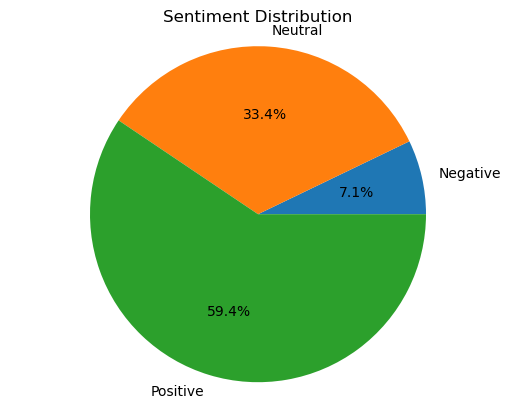

In [26]:
#Creating a Pie Chart
def pie_chart():
    plt.pie(counts, labels=sentiment_label, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title("Sentiment Distribution")
    plt.savefig('dataVisualization/pieChart.png', dpi=300)
    plt.show()

pie_chart()


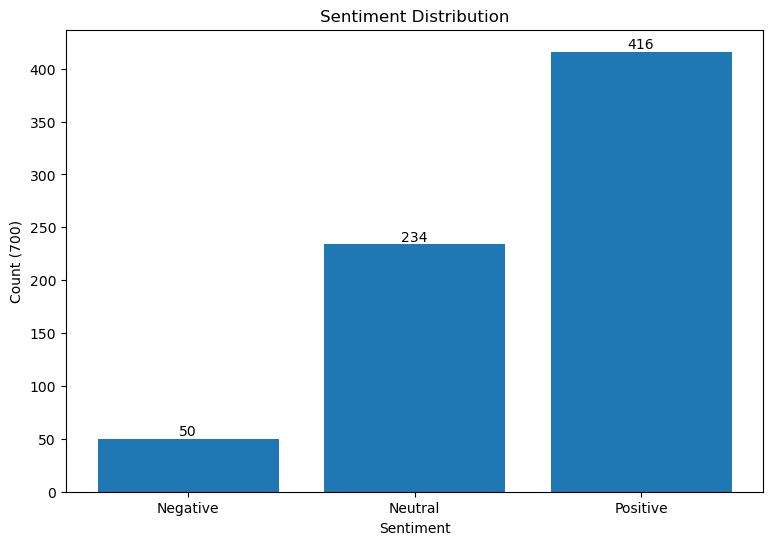

In [28]:
# Create a Bar Chart
def bar_chart():
    plt.figure(figsize=(9,6))
    plt.bar(sentiment_label, counts)
    plt.xlabel('Sentiment')
    plt.ylabel('Count (%d)' %(sum(counts)))
    plt.title('Sentiment Distribution')

    for i, v in enumerate(counts):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.savefig('dataVisualization/barChart.png', dpi=300)
    plt.show()

bar_chart()


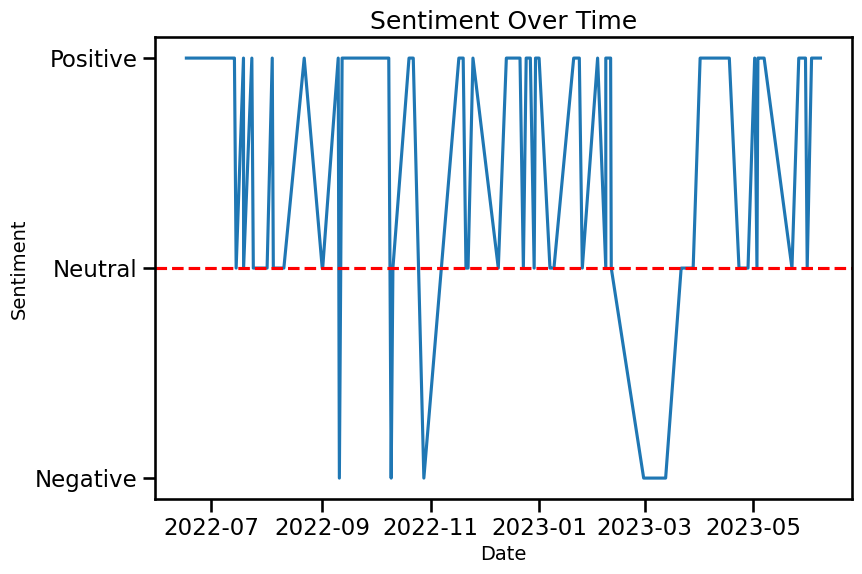

In [29]:
import seaborn as sns

def getDateObjFromStr(date_str):
    return datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ")

# Create a time series plot to see how sentiments change over time
def time_series_plot_past_year(data):
    months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
    video_date_str = video_context["published_date"]
    video_date = getDateObjFromStr(video_date_str)
    today = datetime.now(timezone.utc)
    start_date = today - pd.DateOffset(years=1)
    end_date = today
    
    filtered_df = data[(data['comment_last_updated'] >= start_date) & (data['comment_last_updated'] <= end_date)]
    filtered_df.set_index('comment_last_updated', inplace=True)

    sns.set_context("talk")
    plt.figure(figsize=(9,6))
    sns.lineplot(data=filtered_df, x='comment_last_updated', y='sentiment', errorbar=None)

    plt.axhline(y="Neutral", color='red', linestyle='--')

    plt.xlabel("Date", size=14)
    plt.ylabel("Sentiment", size=14)
    plt.title('Sentiment Over Time')
    plt.savefig("dataVisualization/timeSeriesPlot.png",
                    dpi=150)
    plt.show()

time_series_plot_past_year(comments_df)

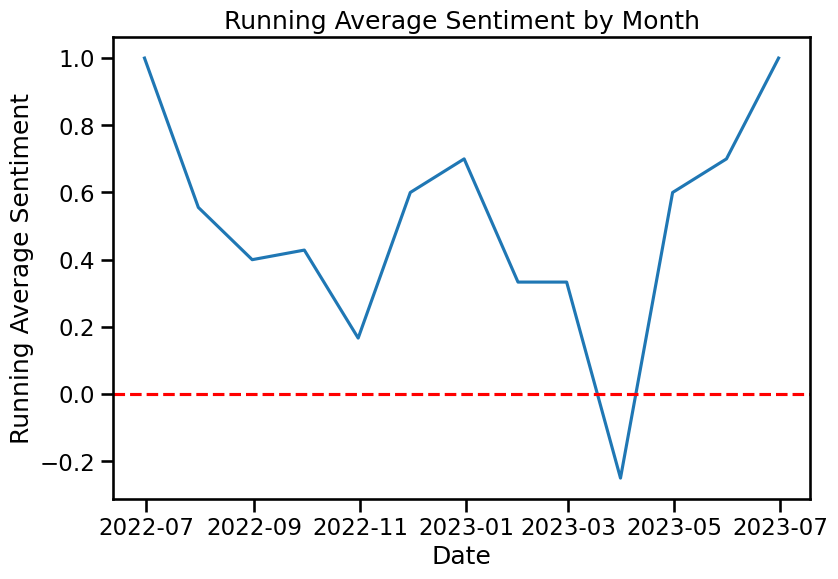

In [30]:

def running_average_by_months(data):
    video_date_str = video_context["published_date"]
    video_date = getDateObjFromStr(video_date_str)
    today = datetime.now(timezone.utc)
    start_date = today - pd.DateOffset(years=1)
    end_date = today
    
    filtered_df = data[(data['comment_last_updated'] >= start_date) & (data['comment_last_updated'] <= end_date)]
    filtered_df.set_index('comment_last_updated', inplace=True)
    
    monthly_avg = filtered_df.groupby(pd.Grouper(freq='M'))['sentiment_values'].mean()
    running_avg = monthly_avg.rolling(window=1, min_periods=1).mean()
    


    plt.figure(figsize=(9,6))
    plt.plot(running_avg.index, running_avg)

    plt.axhline(y=0.0, color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Running Average Sentiment')
    plt.title('Running Average Sentiment by Month')

    plt.savefig('dataVisualization/runningAverage.png', dpi=400)

    plt.show()

running_average_by_months(comments_df)

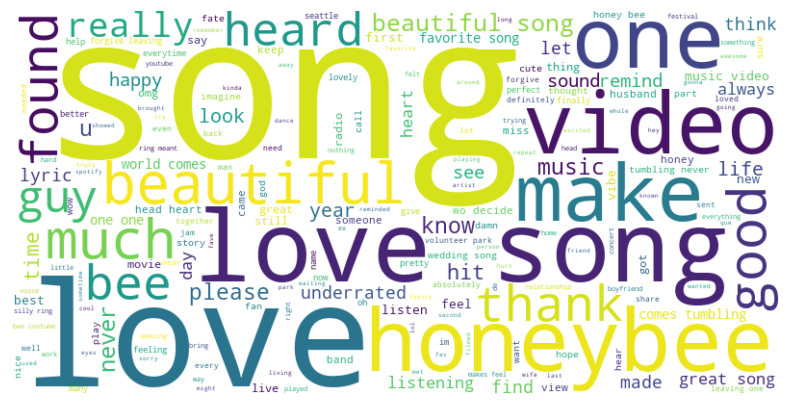

In [31]:
# Create a word cloud
from wordcloud import WordCloud
text = ' '.join(data)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('dataVisualization/wordcloud.png', dpi=300)
plt.show()


In [32]:
# Generate Pdf
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.utils import ImageReader
from reportlab.lib.styles import getSampleStyleSheet
from io import BytesIO

def get_image_dimension(src):
    img_width = 400
    img_height = 0
    image_reader = ImageReader(src)
    img_width_orig, img_height_orig = image_reader.getSize()
    aspect_ratio = img_width_orig / img_height_orig
    img_height = img_width / aspect_ratio
    return (img_height,img_width)

pdf_file_name = "Sentiment Report.pdf"
# Create a buffer to store the PDF
buffer = BytesIO()

pdf = SimpleDocTemplate(buffer, pagesize=letter)

content = []

title =  video_context["title"]
author = "Publisher: " + video_context["video_author"]
video_description = "Video Description: " + video_context["description"]
published_date = "Published On: " + video_context["published_date"]

base_image_width = 400

bar_chart_title = "BarChart"
bar_chart_src = "dataVisualization/barChart.png"
h,w = get_image_dimension(bar_chart_src)
bar_chart_image = Image(bar_chart_src, width=w, height=h)

pie_chart_title = "Pie Chart"
pie_chart_src = "dataVisualization/pieChart.png"
h,w = get_image_dimension(pie_chart_src)
pie_chart_image = Image(pie_chart_src, width=w, height=h)

word_cloud_title = "Word Cloud"
wordcloud_src = "dataVisualization/wordcloud.png"
h,w = get_image_dimension(wordcloud_src)
word_cloud_image = Image(wordcloud_src, width=w, height=h)

time_series_title = "Time Series Plot"
time_series_src = "dataVisualization/timeSeriesPlot.png"
h,w = get_image_dimension(time_series_src)
time_series_image = Image(time_series_src, width=w, height=h)

running_avg_title = "Running Average Plot"
running_avg_src = "dataVisualization/runningAverage.png"
h,w = get_image_dimension(running_avg_src)
running_avg_image = Image(running_avg_src, width=w, height=h)

styles = getSampleStyleSheet()

content.append(Paragraph(title, styles['Title']))
# content.append(Spacer(1, 12))
# content.append(Paragraph(video_description, styles['Normal']))
content.append(Spacer(1, 12))
content.append(Paragraph(author, styles['Normal']))
content.append(Spacer(1, 12))
content.append(Paragraph(published_date, styles['Normal']))
content.append(Spacer(1, 12))
content.append(Spacer(1, 12))
content.append(Paragraph(bar_chart_title, styles['Heading2']))
content.append(bar_chart_image)
content.append(Spacer(1, 12))
content.append(Paragraph(pie_chart_title, styles['Heading2']))
content.append(pie_chart_image)
content.append(Spacer(1, 12))
content.append(Paragraph(word_cloud_title, styles['Heading2']))
content.append(word_cloud_image)
content.append(Spacer(1, 12))
content.append(Paragraph(time_series_title, styles['Heading2']))
content.append(time_series_image)
content.append(Spacer(1, 12))
content.append(Paragraph(running_avg_title, styles['Heading2']))
content.append(running_avg_image)

pdf.build(content)

# Move the buffer's cursor to the beginning
buffer.seek(0)

# Save the PDF to a file
with open(pdf_file_name, "wb") as file:
    file.write(buffer.read())